# Seq2Seq로 번역기 만들기

결과를 보고 싶으신 분은 ctrl(cmd)+f를 누르고 '다시 시작'을 색인하시면 됩니다.

### 서두에 적는 회고
- AI-HUB에 있는 '일상생활 및 구어체 한-영 번역 병렬 말뭉치 데이터'를 사용하여 번역기를 만들었다.
- 학습 결과 어떤 문장을 넣어도 i (m, the, have) Company라는 번역문만 출력하는 결과가 보인다.
- 이에 대해 대체 어떤 연유로 전청조 스타일로 i'm 회사에요라는 결과값을 내는지 찾지 못했다.
- 120만건의 데이터 중 oom문제로 인하여 3만건의 데이터만 불러와서 학습하였다.
- 30 epoch로 학습한 모델로 번역을 진행한 결과 동일한 글자가 여러번 나오는 문제가 나와 토큰화를 공백기반으로 진행하여 이러한 결과가 나온줄 알았지만, 다시 학습해보니 형태소 분석 문제는 아니었다. 30epoch 결과와 30만건의 데이터 학습 디버깅은 가장 최하단에 있습니다.


In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import io
import os

print(tf.__version__)

2.6.0


In [4]:
data_path = os.getenv('HOME')+'/aiffel/korean_english_aihub'

In [5]:
import json, pandas as pd

with open(data_path+'/일상생활및구어체_한영_train_set.json') as f:
    js = json.loads(f.read()) ## json 라이브러리 이용

In [6]:
#AI HUB에서 제공하는 일상생활 및 구어체 한-영 번역 병렬 말뭉치 데이터 데이터 중 train데이터만 사용하고자 함 
print(len(js['data']))
print(js['data'][0]) #여기서 ko가 한국어 원문 , en이 번역, Mt가 기계번역이므로 여기서 사용할 건 Ko,en 두개 변수 사용할 예정

1200000
{'sn': 'INTSALDSUT062119042703238', 'data_set': '일상생활및구어체', 'domain': '해외영업', 'subdomain': '도소매유통', 'ko_original': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'ko': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'mt': 'If you reply to the color you want, we will start making it right away.', 'en': 'If you reply to the color you want, we will start making it right away.', 'source_language': 'ko', 'target_language': 'en', 'word_count_ko': 7, 'word_count_en': 15, 'word_ratio': 2.143, 'file_name': 'INTSAL_DSUT.xlsx', 'source': '크라우드소싱', 'license': 'open', 'style': '구어체', 'included_unknown_words': False, 'ner': None}


In [10]:
df = pd.DataFrame(js['data'])
df.head()
df.tail(1) #야이, 씨가 en 번역으로 see?..기계번역이 조금 더 정확한 것 같은데.. 믿어도 될려나

,sn,data_set,domain,subdomain,ko_original,ko,mt,en,source_language,target_language,word_count_ko,word_count_en,word_ratio,file_name,source,license,style,included_unknown_words,ner
1199999,KPUS062012215065369,일상생활및구어체,일상생활,구매,">야이, 씨!",">야이, 씨!","Hey, shit!",>See?,ko,en,2,1,0.5,구매_KPUS.xlsx,SBS,open,구어체,False,None


In [51]:
df.iloc[757851]
len(df[df['mt']==df['en']]) #기계번역과 영어번역이 동일한 경우 약 71만개

710693

In [52]:
#기계번역과 영어번역이 다른 경우를 확인해 봤는데 큰 차이는 없는 것 같다.
dif = df[df['mt']!=df['en']]
dif[['ko','en','mt']].head(50)

,ko,en,mt
1,형님 제일 웃긴 그림이 뭔지 알아요.,You know what the funniest picture is.,I know what the funniest picture is.
2,>속옷을?,>Underwear?,Underwear?
3,그래도 가격이 꽤 비싸니까 많이 살게요.,I wont buy a lot though since the price is sti...,"However, the price is quite high, so I will bu..."
4,"AAA님, 제가 회의에서 화를 냈던 점 정말 사과드리고 싶습니다.","Dear AAA, I really want to apologize for my an...","AAA, I really want to apologize for being upse..."
7,예 이게 빅데이터 빅이네요.,"Yes, the is big data is big.","Yes, this is Big Data Big."
9,"귀사와의 계약을 취소함에 대해 죄송하게 생각하며, 이에 대한 양해를 구합니다.",We apologize for canceling the contract with y...,We apologize for the cancellation of our contr...
10,>제가 이걸 보여드리겠습니다.,>Let me show you this.,Let me show you this.
13,냉동 만두 주문 의향이 있으시다면 알림 설정을 해주십시오.,"If you are willing to order frozen dumplings, ...",If you are interested in ordering frozen dumpl...
16,우리는 미래를 위한 새로운 솔루션을 제안하기 위해 오래되고 검증된 개념을 채택했습니다.,"We have taken old, proven concept to come up w...",We have adopted old and proven concepts to pro...
18,">지금도, 지금도 보면 다들 고개를 끄덕끄덕했잖아.","> Even now, everyone is nodding.","> Even now, if you look at it now, everyone no..."


In [53]:
# 120만개의 데이터 중에 상위 30만개를 사용하고자 함
# 5어절 미만의 문장도 학습에 크게 상관 없을 것 같아서 일단 상위 30만개로 데이터 선정
# 30만개 결과 oom발생으로 인한 데이터 축소..
df[['ko','en']].iloc[:100000]

,ko,en
0,원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.,"If you reply to the color you want, we will st..."
1,형님 제일 웃긴 그림이 뭔지 알아요.,You know what the funniest picture is.
2,>속옷을?,>Underwear?
3,그래도 가격이 꽤 비싸니까 많이 살게요.,I wont buy a lot though since the price is sti...
4,"AAA님, 제가 회의에서 화를 냈던 점 정말 사과드리고 싶습니다.","Dear AAA, I really want to apologize for my an..."
...,...,...
99995,우리는 우리 제품에 대한 할랄 자격증을 취득하는 데 어려움을 겪고 있습니다.,We are having a trouble getting Halal certific...
99996,그럼 수의학 통계 자료는 어느 분께 드리면 될까요?,"Then, to whom should I give the statistics for..."
99997,저희는 해당 사안을 파악한 뒤 곧바로 해당 직원을 해고하였습니다.,We immediately fired the employee after identi...
99998,현재 귀사는 관광여관을 매우 높은 가격에 납품하고 있습니다.,"Currently, your company supplies tourist inns ..."


In [4]:
#영어/한국어 데이터 전처리 정규표현식에 ㄱ부터 힣까지 추가
#숫자가 필요한 경우도 있기에 숫자도 포함
#문장 앞뒤 Start, end 시퀀스 생성 
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎ가-힣0-9]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence



In [9]:
data = df[['ko','en']].iloc[:30000] #데이터 추출
data.head()

,ko,en
0,원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.,"If you reply to the color you want, we will st..."
1,형님 제일 웃긴 그림이 뭔지 알아요.,You know what the funniest picture is.
2,>속옷을?,>Underwear?
3,그래도 가격이 꽤 비싸니까 많이 살게요.,I wont buy a lot though since the price is sti...
4,"AAA님, 제가 회의에서 화를 냈던 점 정말 사과드리고 싶습니다.","Dear AAA, I really want to apologize for my an..."


In [33]:
#숫자 필요한 예시
#30만개 기준때 작업한 거
print(preprocess_sentence(data['ko'][99999]))
print(preprocess_sentence(data['en'][99999]))

네 .
yes .


In [56]:
from tqdm import tqdm

kor_corpus = []
eng_corpus = []

for i in tqdm(range(len(data))):
    kor_corpus.append(preprocess_sentence(data['ko'][i]))
    eng_corpus.append(preprocess_sentence(data['en'][i], s_token=True, e_token=True))
    
print("kor:", kor_corpus[100])   # go away !
print("eng:", eng_corpus[100])   # <start> salga de aqu ! <end>

100%|██████████| 30000/30000 [00:01<00:00, 19774.22it/s]

kor: 빨리 , 빨리 .
eng: <start> quick , quick . <end>


In [57]:
#토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


In [58]:
#데이터 토큰화 처리 및 데이터 셋 분할 진행
from sklearn.model_selection import train_test_split

kor_tokenizer = tokenize(kor_corpus)[1]
eng_tokenizer = tokenize(eng_corpus)[1]

kor_tensor = tokenize(kor_corpus)[0]
eng_tensor = tokenize(eng_corpus)[0]

kor_train, kor_val, eng_train, eng_val = \
train_test_split(kor_tensor, eng_tensor, test_size=0.2)

In [86]:
kor_tensor[0]

array([ 413, 1147, 1523,  196,   80,  856, 5759,    1,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [59]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [60]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [61]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [62]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024 #데이터 10만개 기준 256
embedding_dim = 512 #데이터 10만개 기준 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30 #문장길이 분포 최대 30어절

sample_kor = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_kor)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 13921)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [63]:
#옵티마이저 및 로스
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [70]:
#train step
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        kor_out = encoder(src)
        h_dec = kor_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, kor_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [21]:
# %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [72]:
import random

@tf.function
def eval_step(src, tgt, encoder, decoder, eng_tok):
    bsz = src.shape[0]
    loss = 0

    kor_out = encoder(src)

    h_dec = kor_out[:, -1]
    
    eng_src = tf.expand_dims([eng_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(eng_src, h_dec, kor_out)

        loss += loss_function(tgt[:, t], pred)
        eng_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 30: 100%|██████████| 94/94 [00:24<00:00,  3.80it/s, Test Loss 1.1393]


Input: 이거 번역이 잘 되려나 모르겠네
Predicted translation: this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this 


/tmp/ipykernel_31/4071588706.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/4071588706.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50669 missing from current 

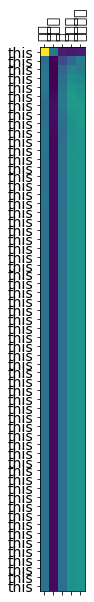

In [74]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_train.shape[-1],
                                                           padding='post')

    result = ''

    kor_out = encoder(inputs)

    eng_hidden = kor_out[:, -1]
    eng_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_train.shape[-1]):
        predictions, eng_hidden, attention_weights = decoder(eng_input,
                                                             eng_hidden,
                                                             kor_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("이거 번역이 잘 되려나 모르겠네", encoder, decoder)

Input: 나는 괜찮아
Predicted translation: it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it 


/tmp/ipykernel_31/4071588706.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/4071588706.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


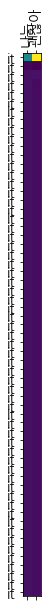

In [98]:
plt.rcParams["font.family"] = "NanumGothic" #맑은 고딕으로 폰트 변경
translate("나는 괜찮아", encoder, decoder)

In [81]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    if 'Malgun' in font.name:
        print(font.name, font.fname)

In [1]:
#커널 죽어버렸네..
#데이터 축소할게요..
#데이터 10만개는 돌아갈만 하지 않나..?
#아 왜!
# print('ㅜㅜ')
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# 다시 시작

In [5]:
from tqdm import tqdm
import json, pandas as pd
from konlpy.tag import Mecab



data_path = os.getenv('HOME')+'/aiffel/korean_english_aihub' #파일경로설정

with open(data_path+'/일상생활및구어체_한영_train_set.json') as f: 
    js = json.loads(f.read()) ## json 라이브러리 이용

    
num_data = 30000
    
df = pd.DataFrame(js['data']) #데이터 프레임 생성
data = df[['ko','en']].iloc[:num_data] #데이터 추출

enc_corpus = []
dec_corpus = []

for i in tqdm(range(len(data))):
    enc_corpus.append((preprocess_sentence(data['ko'][i])))
    dec_corpus.append(preprocess_sentence(data['en'][i], s_token=True, e_token=True))
    
print("kor:", enc_corpus[100])   # go away !
print("eng:", dec_corpus[100])   # <start> salga de aqu ! <end>

100%|██████████| 30000/30000 [00:01<00:00, 29351.25it/s]

kor: 빨리 , 빨리 .
eng: <start> quick , quick . <end>


In [6]:
from tqdm import tqdm
mec = Mecab()

mec.morphs(enc_corpus[0])

X_mec_test = []
for sentence in tqdm(enc_corpus):
    tokenized_sentence = mec.morphs(sentence) # 토큰화
#     stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_mec_test.append(tokenized_sentence)

100%|██████████| 30000/30000 [00:04<00:00, 7427.87it/s] 


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

# X_mec_test[:3]
enc_tokenizer = Tokenizer()
enc_tokenizer.fit_on_texts(X_mec_test)
enc_tensor = enc_tokenizer.texts_to_sequences(X_mec_test)
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, padding='post')

In [9]:
#토큰화 이부분에서 한국어 부분만 따로 처리해야함
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


#데이터 토큰화 처리 및 데이터 셋 분할 진행
from sklearn.model_selection import train_test_split

# kor_tokenizer = tokenize(kor_corpus)[1]
dec_tokenizer = tokenize(dec_corpus)[1]

# kor_tensor = tokenize(kor_corpus)[0]
dec_tensor = tokenize(dec_corpus)[0]

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [10]:
enc_tensor

array([[ 188,    3,   27, ...,    0,    0,    0],
       [ 128,   53,  849, ...,    0,    0,    0],
       [5636,    2,   16, ...,    0,    0,    0],
       ...,
       [  93,    8,   48, ...,    0,    0,    0],
       [ 280, 1356,    2, ...,    0,    0,    0],
       [ 581,    4,   15, ...,    0,    0,    0]], dtype=int32)

In [11]:
#bahdanau_attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [13]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 13921)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [15]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [17]:
import random
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:33<00:00,  2.84it/s, Test Loss 1.1214]


In [44]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [05:47<00:00,  1.08it/s, Loss 1.0415]


In [60]:
kor_train[1]


from tensorflow.keras.preprocessing.text import Tokenizer

mec.morphs(sentence)

# X_mec_test[:3]
kor_tokenizer = Tokenizer()
kor_tokenizer.fit_on_texts(X_mec_test)
kor_tensor = tokenizer_mec.texts_to_sequences(X_mec_test)
kor_tensor = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor, padding='post')

array([4732,  355,  118,   30,   11,  177,    2,  101,   70,    3,    4,
         22,   60,   24,   21,   71,   59,   13, 1159,    5,  306,   22,
         58,  175,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


In [86]:
kor_train[0]

array([ 111,    7,   95,   32, 2680,   23,   20,  146,   83,   18,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

Input: 글쎄요 , 저희는 트럭 한 대에 5 , 000개의 제품을 가지고 있습니다 .
Predicted translation: i m the company . <end> 


/tmp/ipykernel_118/601835555.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_118/601835555.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


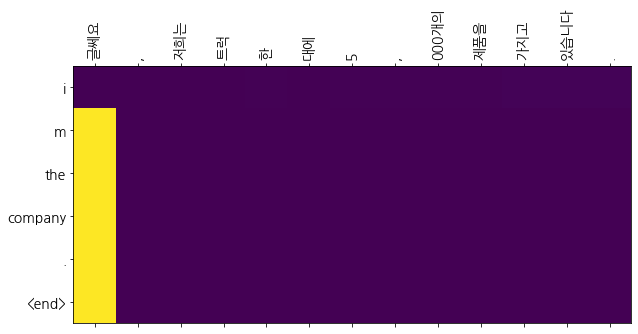

In [39]:
# translate("이거 뭘 하든 같은 단어만 나올 삘인데?", encoder, decoder)
plt.rcParams["font.family"] = "NanumGothic" #맑은 고딕으로 폰트 변경
str_txt = enc_corpus[75]
translate(str_txt, encoder, decoder)

Input: 이건 제대로 되는건지 잘 모르겠네요
Predicted translation: the company . <end> 


/tmp/ipykernel_76/3675406126.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_76/3675406126.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


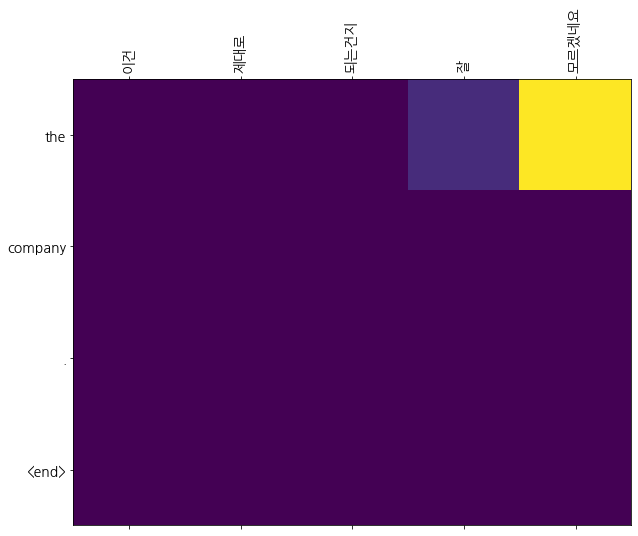

Input: 안녕하세요 여러분 제가 질문이 있는데 이게 맞는지 모르겠어요
Predicted translation: hello , i have a company . <end> 


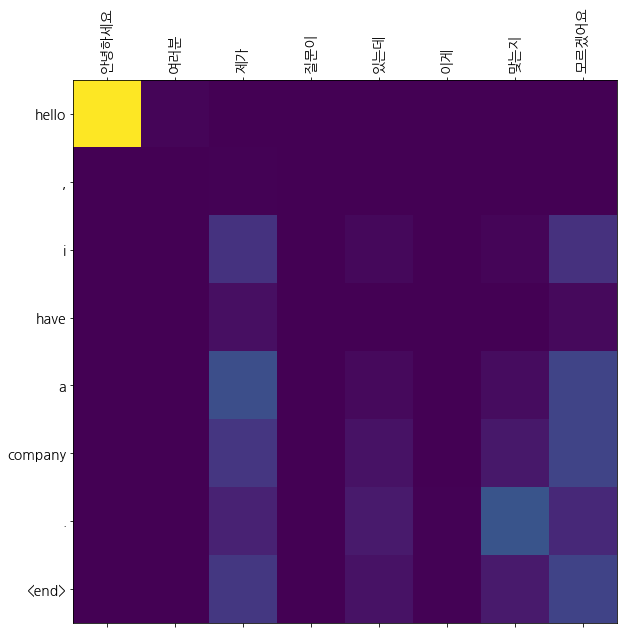

In [85]:
plt.rcParams["font.family"] = "NanumGothic" #맑은 고딕으로 폰트 변경
translate("이건 제대로 되는건지 잘 모르겠네요", encoder, decoder)
translate("안녕하세요 여러분 제가 질문이 있는데 이게 맞는지 모르겠어요", encoder, decoder)


In [62]:
#30만개 문장 돌렸을 경우 발생했던 
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

  0%|          | 0/3750 [01:49<?, ?it/s]


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,33434] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/decoder/dense/MatMul_81 (defined at tmp/ipykernel_31/3221489718.py:22) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_167762]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/decoder/dense/MatMul_81:
 decoder/Reshape_51 (defined at tmp/ipykernel_31/285261603.py:20)

Function call stack:
train_step


In [64]:
# Define eval_step
#이전기록
import random

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:33<00:00,  2.80it/s, Test Loss 1.0830]


In [ ]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, kor_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_val[idx:idx+BATCH_SIZE],
                                    eng_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))